<font size="+3"><strong>Project: Predicting Apartment Prices in Mexico City 🇲🇽</strong></font>

In [16]:
# Import libraries here
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import plotly.express as px
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

We are going to write a `wrangle` function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City (`"Distrito Federal"`) that cost less than \$100,000.
2. Remove outliers by trimming the bottom and top 10\% of properties in terms of `"surface_covered_in_m2"`.
3. Create separate `"lat"` and `"lon"` columns.
4. Mexico City is divided into [16 boroughs](https://en.wikipedia.org/wiki/Boroughs_of_Mexico_City). Create a `"borough"` feature from the `"place_with_parent_names"` column.
5. Drop columns that are more than 50\% null values.
6. Drop columns containing low- or high-cardinality categorical values. 
7. Drop any columns that would constitute leakage for the target `"price_aprox_usd"`.
8. Drop any columns that would create issues of multicollinearity. 

In [17]:
df = pd.read_csv("data/mexico-city-real-estate-1.csv")
#df = df[ ] 
df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851852,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481481,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


In [18]:
# mask_price = df['price_aprox_usd'] < 100000
# mask_apt = df["place_with_parent_names"].str.contains("Distrito Federal")
# mask_apt.unique()

# df[["lat", "lon"]] = df["lat-lon"].str.split(",-", expand = True).astype(float)
# df[["lat", "lon"]]

# df["borough"] = df["place_with_parent_names"].str.split("|", expand = True)[1]
# df["borough
#df.columns.value_counts()
#df.isnull().sum() / len(df)
# df.drop(columns = ["floor", "expenses", "rooms", "surface_total_in_m2", "price_usd_per_m2"], inplace = True)

#df.select_dtypes("object").nunique()
# corr = df.select_dtypes("number").drop(columns = "price_aprox_usd").corr()
# sns.heatmap(corr)



In [19]:
# Build your `wrangle` function
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    #mask price and district
    mask_price = df['price_aprox_usd'] < 100000
    mask_apt = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_ppt = df["property_type"] == "apartment"
    
    df = df[mask_price & mask_apt & mask_ppt]
    
    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    #lat and lon
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    #boroughs
    df["borough"] = df["place_with_parent_names"].str.split("|", expand = True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    #Drop over 50% null
    df.drop(columns = ["floor", "expenses", "rooms", "surface_total_in_m2", "price", "price_usd_per_m2"], inplace = True)
    
    #Low and High cardinality chop off
    df.drop(columns = ["operation", "currency", "properati_url", "property_type"], inplace = True)
    
    #drop leaky features
    df.drop(columns = ["price_aprox_local_currency", "price_per_m2"], inplace = True)
    
     #corr = df.select_dtypes("number").drop(columns = "price_aprox_usd").corr()
     #sns.heatmap(corr)
    
    
    return df


In [20]:
tf = wrangle("data/mexico-city-real-estate-1.csv")
tf.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [21]:
# Use this cell to test your wrangle function and explore the data


Let's use glob to create the list `files`. It should contain the filenames of all the Mexico City real estate CSVs in the `./data` directory, except for `mexico-city-test-features.csv`.

In [22]:
files = glob("data/mexico-city-real-estate-*.csv")
files

['data\\mexico-city-real-estate-1.csv']

Combine your `wrangle` function, a list comprehension, and `pd.concat` to create a DataFrame `df`. It should contain all the properties from the five CSVs in `files`. 

In [23]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 11 to 4605
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1101 non-null   float64
 1   surface_covered_in_m2  1101 non-null   float64
 2   lat                    1041 non-null   float64
 3   lon                    1041 non-null   float64
 4   borough                1101 non-null   object 
dtypes: float64(4), object(1)
memory usage: 47.3+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


## Explore

Let's create a histogram showing the distribution of apartment prices (`"price_aprox_usd"`) in `df`. Be sure to label the x-axis `"Area [sq meters]"`, the y-axis `"Count"`, and give it the title `"Distribution of Apartment Prices"`.

What does the distribution of price look like? Is the data normal, a little skewed, or very skewed?

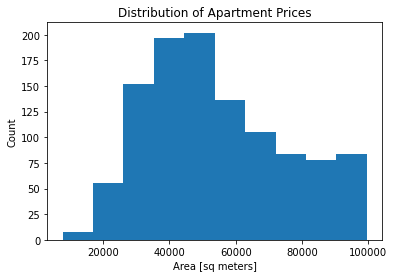

In [24]:
# Plot distribution of price
plt.hist(df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Count")
plt.title("Distribution of Apartment Prices");

Let's create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`). Be sure to label your axes `"Price [USD]"` and `"Area [sq meters]"`, respectively. Your plot should have the title `"Mexico City: Price vs. Area"`.

Do you see a relationship between price and area in the data? How is this similar to or different from the Buenos Aires dataset?

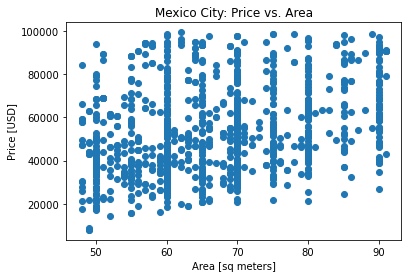

In [26]:
# Plot price vs area

plt.scatter(x = df["surface_covered_in_m2"], y = df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area");

Let's create a Mapbox scatter plot that shows the location of the apartments in your dataset and represent their price using color. 

What areas of the city seem to have higher real estate prices?

In [ ]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon='lon',
    width=600,  # Width of map
    height=600,  # Height of map
    color='price_aprox_usd',
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

## Split

Let's create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.

In [ ]:
df.head()

In [ ]:
# Split data into feature matrix `X_train` and target vector `y_train`.
features = ["surface_covered_in_m2", "lat", "lon", "borough"]
target = "price_aprox_usd"
X_train = df[features]
y_train = df[target]

# Build Model

## Baseline

Calculate the baseline mean absolute error for your model.

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

## Iterate

Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data.

In [ ]:
# Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

## Evaluate

Read the CSV file `mexico-city-test-features.csv` into the DataFrame `X_test`.

In [ ]:
X_test = pd.read_csv("data/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

Use the model to generate a Series of predictions for `X_test`.

In [ ]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

# Communicate Results

Create a Series named `feat_imp`. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.  

In [ ]:
coefficients = model.named_steps['ridge'].coef_
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index = features)
feat_imp

Create a horizontal bar chart that shows the **10 most influential** coefficients for your model. Be sure to label your x- and y-axis `"Importance [USD]"` and `"Feature"`, respectively, and give your chart the title `"Feature Importances for Apartment Price"`.